In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches


## Data Cleaning

In [4]:
#Load in Data Set
df = pd.read_csv("data/bluebikeSummers.csv")  #, parse_dates=["started_at", "ended_at"]
stationinfo = pd.read_excel("data/raw_bluebike/bluebikes_station_list.xlsx", header = 1)  #had to install smth to use this #headr = 0 to make the first row the header

In [5]:
df.columns = df.columns.str.lower() #consistent column titles
# convert to date time
df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce")
df["ended_at"] = pd.to_datetime(df["ended_at"], errors="coerce")

#add a column for log transformation of trip duration to account for outliers
df["log_tripduration"] = np.log(df["tripduration"]+1) #plus one so no log 0

df['month'] = pd.to_datetime(df['started_at']).dt.month_name() #get the month

df.head()

,tripduration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,bikeid,member_casual,postal_code,year,log_tripduration,month
0,13,2022-06-01 00:00:08.495000+00:00,2022-06-01 00:13:06.386000+00:00,462,Linwood St at Minuteman Bikeway,42.409354,-71.149065,142,Alewife Station at Russell Field,42.396105,-71.139459,7025,member,02138,2022,2.639057,June
1,12,2022-06-01 00:00:09.725000+00:00,2022-06-01 00:11:49.479000+00:00,515,955 Mass Ave,42.368952,-71.109988,115,Porter Square Station,42.387995,-71.119084,4454,member,02144,2022,2.564949,June
2,7,2022-06-01 00:00:12.231000+00:00,2022-06-01 00:07:32.178000+00:00,76,Central Sq Post Office / Cambridge City Hall a...,42.366426,-71.105495,544,Old Morse Park at Putnam Ave,42.357662,-71.108413,7397,member,02138,2022,2.079442,June
3,12,2022-06-01 00:00:21.125000+00:00,2022-06-01 00:12:25.786000+00:00,55,Boylston St at Massachusetts Ave,42.347406,-71.086784,364,Tremont St at Northampton St,42.338432,-71.081690,2942,member,17961,2022,2.564949,June
4,6,2022-06-01 00:00:42.279000+00:00,2022-06-01 00:06:50.654000+00:00,81,Chinatown T Stop,42.352409,-71.062679,536,Clinton St at North St,42.360703,-71.055249,3304,member,02109,2022,1.945910,June


In [6]:
df.head()
df['month'].value_counts()
#df['year'].unique()

month
August    486740
July      430183
June      388154
Name: count, dtype: int64

## Data Exploration

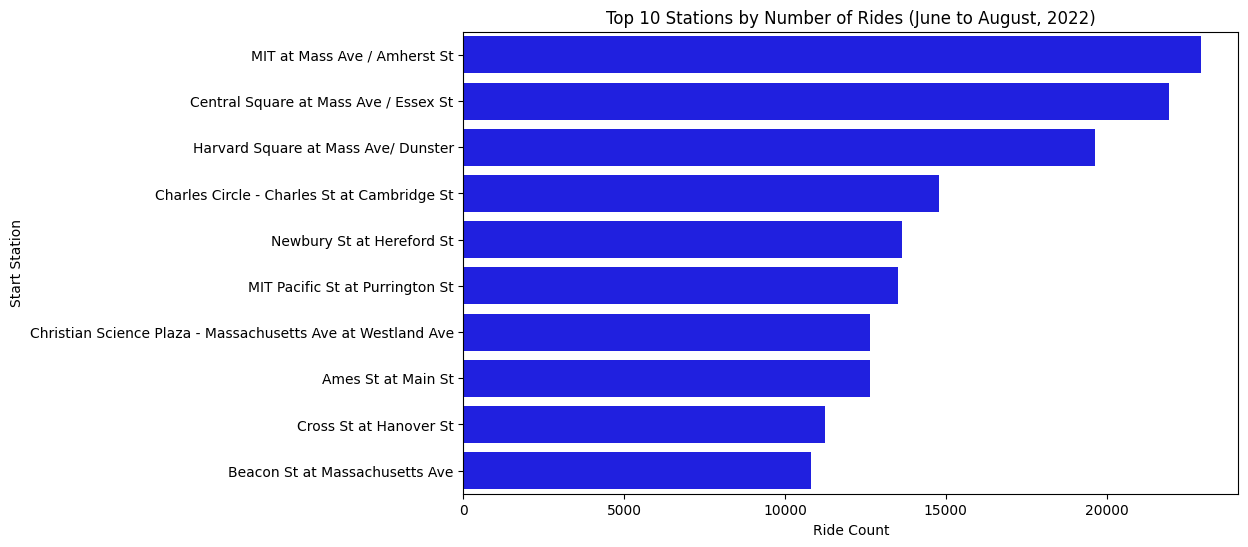

In [7]:
#Top stations by number of rides, bar chart
top_stations= df["start_station_name"].value_counts().nlargest(10).reset_index()
top_stations.columns = ["start_station_name", "n"]

plt.figure(figsize=(10, 6))
sns.barplot(y="start_station_name", x="n", data=top_stations, color="blue")
plt.title("Top 10 Stations by Number of Rides (June to August, 2022)")
plt.xlabel("Ride Count")
plt.ylabel("Start Station")
plt.show()

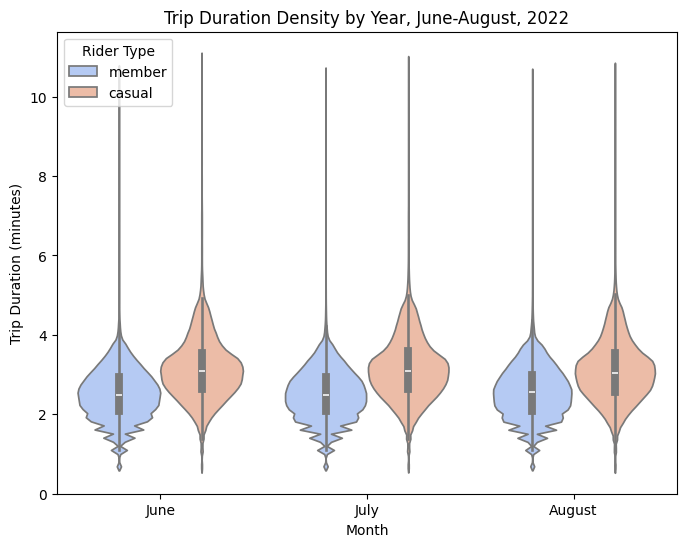

In [33]:
#Violin plot for trip duration
plt.figure(figsize=(8, 6))
sns.violinplot(x="month", y="log_tripduration", hue="member_casual", data=df, palette="coolwarm", order=["June", "July", "August"])
plt.title("Trip Duration Density by Year, June-August, 2022")
plt.xlabel("Month")
plt.ylabel("Trip Duration (minutes)")
plt.legend(title="Rider Type")
plt.show()


<Axes: xlabel='month', ylabel='log_tripduration'>

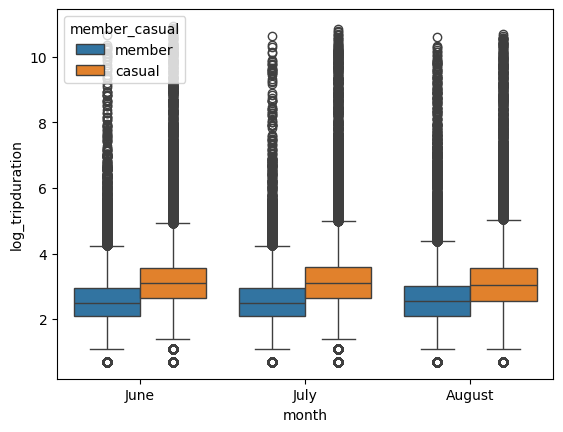

In [9]:
#just checking to make sure even if all three months look same, that they aren't exactly the
#same by some mistake
sns.boxplot(
    x="month", 
    y="log_tripduration", 
    hue="member_casual", 
    data=df
)


## Accumulation of Net Flow Per Station

In [10]:
df["date"] = df["started_at"].dt.date  #create new column with only the date so can group by date below
#count bikes picked up and dropped off
pickups = df.groupby(["start_station_id", "date"]).size().reset_index(name="pickups") #new df with number of pickups of bikes from a station each day
dropoffs = df.groupby(["end_station_id", "date"]).size().reset_index(name="dropoffs")
#print(pickups)
#dropoffs.head()
#merge pickups and dropoffs so that each row is a station on a day. it has columns for station ID
#pickup of bikes that day, and dropoff of bikes that day
flow = pd.merge(dropoffs, pickups, left_on=["end_station_id", "date"], right_on=["start_station_id", "date"], how="outer")

#the fill "missing values" with 0 (some stations may only have drop-offs or pickups and merged these appear
#as NaN)
print(df["start_station_id"].isna().sum())  #verifies that the NaN is not from data itself so it represents 0
print(df["end_station_id"].isna().sum())  #pickup/dropoff

flow["dropoffs"] = flow["dropoffs"].fillna(0)
flow["pickups"] = flow["pickups"].fillna(0)
#print((flow["dropoffs"] == 0).sum())  #Total number of 0s in dropoffs
#print((flow["pickups"] == 0).sum())

#net flow of bikes for each station-day
flow["net_flow"] = flow["dropoffs"] - flow["pickups"]

#average net flow by grouping by station
station_flow = flow.groupby("end_station_id")["net_flow"].mean().reset_index()

0
0


In [11]:
display(flow)

,end_station_id,date,dropoffs,start_station_id,pickups,net_flow
0,1.0,2022-06-02,1.0,NaN,0.0,1.0
1,1.0,2022-06-03,1.0,NaN,0.0,1.0
2,1.0,2022-06-04,6.0,NaN,0.0,6.0
3,1.0,2022-06-05,5.0,NaN,0.0,5.0
4,1.0,2022-06-06,3.0,NaN,0.0,3.0
...,...,...,...,...,...,...
37976,NaN,2022-08-28,0.0,571.0,2.0,-2.0
37977,571.0,2022-08-29,1.0,571.0,2.0,-1.0
37978,NaN,2022-08-25,0.0,572.0,1.0,-1.0
37979,572.0,2022-08-29,1.0,NaN,0.0,1.0


In [13]:
#each row is a singular station with pickups/dropoffs
#becusae previous ways of merging meant that there are two columns for the same station id
#want to combine them into one
flow["station_id"] = flow["end_station_id"].combine_first(flow["start_station_id"]).astype(int)

In [14]:
#calculates a singular number for flow
station_flow = flow.groupby("station_id")["net_flow"].mean().reset_index() #averages all the daily flows
station_flow = station_flow.rename(columns={"net_flow": "avg_net_flow"}) #rename column


## Clustering

In [15]:
#column used for clustering (the net flow of bikes)
X = station_flow[["avg_net_flow"]]

#k means clustering (try with 3 groups)
kmeans = KMeans(n_clusters=3, random_state=42)
station_flow["cluster"] = kmeans.fit_predict(X) #assign each station to a cluster hopefully three diff
#groups representing sinks (Stations that are gaining bikes), sources (stations that are losign bikes),
#and balance groups

C:\Users\baobr\AppData\Local\Temp\ipykernel_7804\736229232.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(station_flow["station_id"], station_flow["avg_net_flow"],


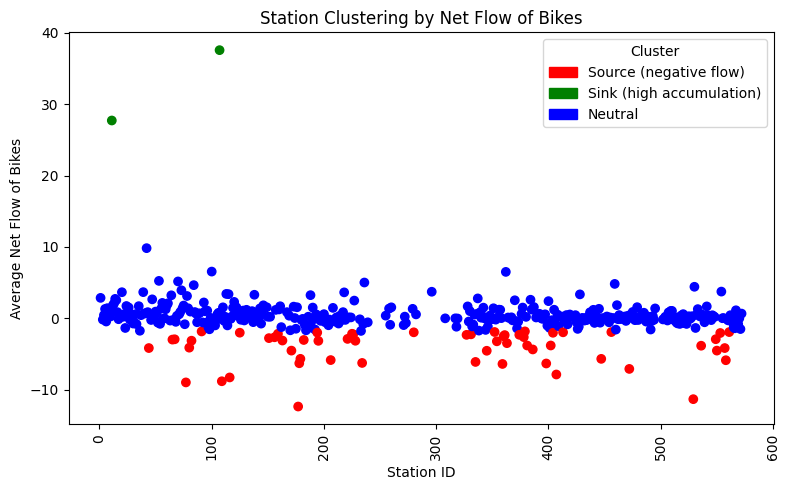

In [16]:
cluster_colors = {
    0: "red",
    1: "green",
    2: "blue"
}

#Graph to look at clustering
plt.figure(figsize=(8, 5))
plt.scatter(station_flow["station_id"], station_flow["avg_net_flow"],
            c=station_flow["cluster"].map(cluster_colors), cmap="viridis")
plt.xlabel("Station ID")
plt.ylabel("Average Net Flow of Bikes")
plt.title("Station Clustering by Net Flow of Bikes")
plt.xticks(rotation=90)
plt.tight_layout()

label_map = {
    0: "Source (negative flow)",
    1: "Sink (high accumulation)",
    2: "Neutral"
}
legend = [
    mpatches.Patch(color=color, label=label_map[cluster])
    for cluster, color in cluster_colors.items()
]
plt.legend(handles=legend, title="Cluster")

plt.tight_layout()
plt.show()
#may choose to get rid of, binary classification nstead of

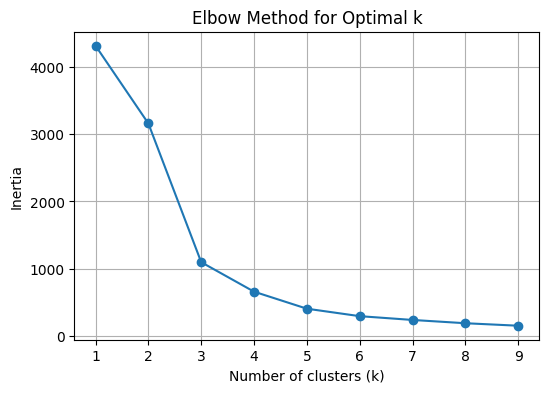

In [17]:
inertias = []  #Array to store all the intertias
K_range = range(1, 10)  #k from 1 to 9

for k in K_range:   #loop through each of the ks to calculate the intertias
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

#visualize the kmeans on grpah to see where elbow is
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

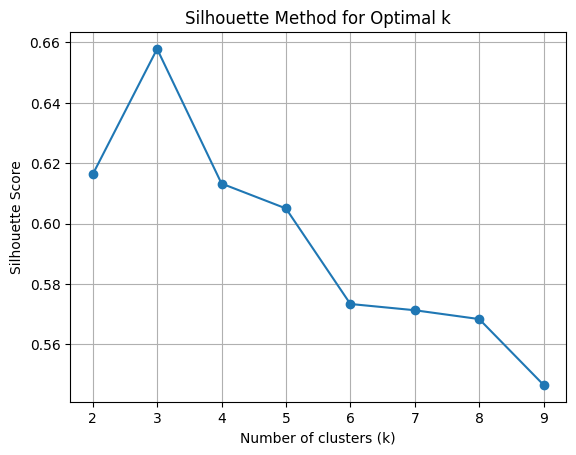

In [18]:
from sklearn.metrics import silhouette_score

silhouette_scores = []  #array to store the scores for each k

for k in range(2, 10):  #get the score for each k from 2-10, and append to array
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)  #function that looks at how well clustered the data are for a k, gets the score
    silhouette_scores.append(score)

#visualize
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.grid(True)
plt.show()


### Showing KMeans On Map

In [19]:
#To prepare to show kmeans on map
#Create dataframe with lat/lng for each station
station_coords = df.groupby("start_station_id")[["start_lat", "start_lng"]].mean().reset_index()  #get the avg lat/long for each station
station_coords = station_coords.rename(columns={
    "start_station_id": "station_id",
    "start_lat": "lat",
    "start_lng": "lng"
})

#merge with dataframe that has which cluster each station is in
station_map = pd.merge(station_flow, station_coords, on="station_id", how="left")
station_map["station_id"] = station_map["station_id"].astype(int)  #station id no decimals, no .0
station_map

,station_id,avg_net_flow,cluster,lat,lng
0,1,2.869048,2,42.387151,-71.075978
1,3,-0.173913,2,42.340115,-71.100619
2,4,0.456522,2,42.345392,-71.069616
3,5,1.315217,2,42.341814,-71.090179
4,6,-0.445652,2,42.361257,-71.065287
...,...,...,...,...,...
432,568,0.590909,2,42.335846,-71.080382
433,569,-0.800000,2,42.380045,-71.073046
434,570,0.000000,2,42.503332,-70.891444
435,571,-1.500000,2,42.506395,-70.886930


In [20]:
#Get the station names
station_names = df[["start_station_id", "start_station_name"]].drop_duplicates()
station_names = station_names.rename(columns = {
    "start_station_id": "station_id",
    "start_station_name": "station_name"
})

#merge with station map
station_map = pd.merge(station_map, station_names, on="station_id", how="left")
station_map


,station_id,avg_net_flow,cluster,lat,lng,station_name
0,1,2.869048,2,42.387151,-71.075978,18 Dorrance Warehouse
1,3,-0.173913,2,42.340115,-71.100619,Colleges of the Fenway - Fenway at Avenue Loui...
2,4,0.456522,2,42.345392,-71.069616,Tremont St at E Berkeley St
3,5,1.315217,2,42.341814,-71.090179,Northeastern University - North Parking Lot
4,6,-0.445652,2,42.361257,-71.065287,Cambridge St at Joy St
...,...,...,...,...,...,...
432,568,0.590909,2,42.335846,-71.080382,Shawmut Ave at Lenox St
433,569,-0.800000,2,42.380045,-71.073046,Hood Park
434,570,0.000000,2,42.503332,-70.891444,Salem State University - North Campus
435,571,-1.500000,2,42.506395,-70.886930,Forest River Park


In [21]:
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[42.36, -71.06], zoom_start=13)  #start the map around boston

#color of each station represnets clusters, correspond with our graph above
colors = ["red", "green", "blue"]

#markers on the map
for _, row in station_map.iterrows():
    cluster_color = colors[int(row["cluster"]) % len(colors)]
    #shows text when you click on a dot
    popup_text = f"""<div style="width:150px;"> 
                        <b>Station:</b> {row['station_name']}<br>
                        <b>Station ID:</b> {int(row['station_id'])}<br>
                        <b>Avg Net Flow:</b> {row['avg_net_flow']:.2f}
                    </div>
                """
    popup = folium.Popup(popup_text, max_width=200)
    
    #how we want each marker for station to look
    folium.CircleMarker(
        location=[row["lat"], row["lng"]],
        radius=6,
        color=cluster_color,
        fill=True,
        fill_color=cluster_color,
        fill_opacity=0.7,
        popup=popup_text
    ).add_to(m)

# Show map
m


In [22]:
#summary statistics for each cluster
cluster_summary = station_flow.groupby("cluster")["avg_net_flow"].describe()
print(cluster_summary)


         count       mean       std        min        25%        50%  \
cluster                                                                
0         59.0  -4.113932  2.413213 -12.358696  -5.675845  -3.141304   
1          2.0  32.657609  6.971151  27.728261  30.192935  32.657609   
2        376.0   0.469764  1.377828  -1.760870  -0.242954   0.213634   

               75%        max  
cluster                        
0        -2.277174  -1.826087  
1        35.122283  37.586957  
2         0.883152   9.836957  


In [19]:
m.save("ds350h_assignment8_map.html")

## Data Cleaning for Prediction of Clusters in R

In [23]:
print(station_map[station_map["cluster"] == 1])

    station_id  avg_net_flow  cluster        lat       lng  \
9           11     27.728261        1  42.338629 -71.10650   
96         107     37.586957        1  42.362500 -71.08822   

                 station_name  
9   Longwood Ave at Binney St  
96         Ames St at Main St  


In [24]:
#CSV for the bike station data
stationinfo.columns = stationinfo.columns.str.lower() #consistent column titles
stationinfo.rename(columns = {'station id (to match to historic system data)': "station_id"},  inplace = True)
stationinfo

,number,name,lat,long,seasonal status,municipality,total docks,station_id
0,L32001,Railroad Lot and Minuteman Bikeway,42.416065,-71.153366,Year Round,Arlington,11,461
1,L32002,Linwood St at Minuteman Bikeway,42.409354,-71.149065,Year Round,Arlington,11,462
2,L32005,Thorndike Field at Minuteman Bikeway,42.400168,-71.144570,Year Round,Arlington,11,480
3,L32003,Mass Ave at Grafton St,42.407261,-71.143821,Year Round,Arlington,11,464
4,L32004,Broadway at Grafton St,42.409942,-71.140093,Winter Storage,Arlington,11,465
...,...,...,...,...,...,...,...,...
527,C32011,Harbor St at Channel St,42.345144,-71.036453,Year Round,Boston,16,No ID pre-March 2023
528,C32071,Northern Ave at Haul Rd,42.347181,71.035796,Year Round,Boston,20,No ID pre-March 2023
529,C32070,300 Summer St,42.349784,-71.048935,Year Round,Boston,15,No ID pre-March 2023
530,R32003,Beachmont Square at Suffolk Downs,42.397608,-70.993072,Year Round,Revere,11,No ID pre-March 2023


In [25]:
merged_station = pd.merge(station_map, stationinfo, on = "station_id", how = "inner")
merged_station = merged_station.drop(columns = ["lat_y", "long", "name", "number"]) #drop columns don't need
merged_station.rename(columns = {'lat_x': "lat", 'seasonal status': "seasonal_status", 'total docks': "total_docks"},  inplace = True)
merged_station

,station_id,avg_net_flow,cluster,lat,lng,station_name,seasonal_status,municipality,total_docks
0,3,-0.173913,2,42.340115,-71.100619,Colleges of the Fenway - Fenway at Avenue Loui...,Year Round,Boston,15
1,4,0.456522,2,42.345392,-71.069616,Tremont St at E Berkeley St,Year Round,Boston,19
2,5,1.315217,2,42.341814,-71.090179,Northeastern University - North Parking Lot,Winter Storage,Boston,15
3,6,-0.445652,2,42.361257,-71.065287,Cambridge St at Joy St,Year Round,Boston,15
4,7,1.423913,2,42.353391,-71.044571,Fan Pier,Year Round,Boston,15
...,...,...,...,...,...,...,...,...,...
423,568,0.590909,2,42.335846,-71.080382,Shawmut Ave at Lenox St,Year Round,Boston,19
424,569,-0.800000,2,42.380045,-71.073046,Hood Park,Year Round,Boston,23
425,570,0.000000,2,42.503332,-70.891444,Salem State University - North Campus,Year Round,Salem,11
426,571,-1.500000,2,42.506395,-70.886930,Forest River Park,Year Round,Salem,11


In [26]:
merged_station.to_csv("C:/Users/baobr/OneDrive/Desktop/DS350H/FinalProject/Data/stationdata.csv", index = False)

## Bonus Clustering with Total Docks (Not included in presentation)

In [27]:
from sklearn.preprocessing import StandardScaler

In [30]:
#copy rows we want to include, here extra total docks in k clustering
clusterdata = merged_station[["avg_net_flow", "total_docks"]].copy()
scaler = StandardScaler()  #standarizes values, feature scaling
scaled = scaler.fit_transform(clusterdata)

kmeans = KMeans(n_clusters=3, random_state=12)  #random_state = 42 is like setting seed, makes reproducible
clusterdata["cluster_kmeans"] = kmeans.fit_predict(scaled)  #assigns each row to a cluster

#clusterdata["original_cluster"] = station_map["cluster"]

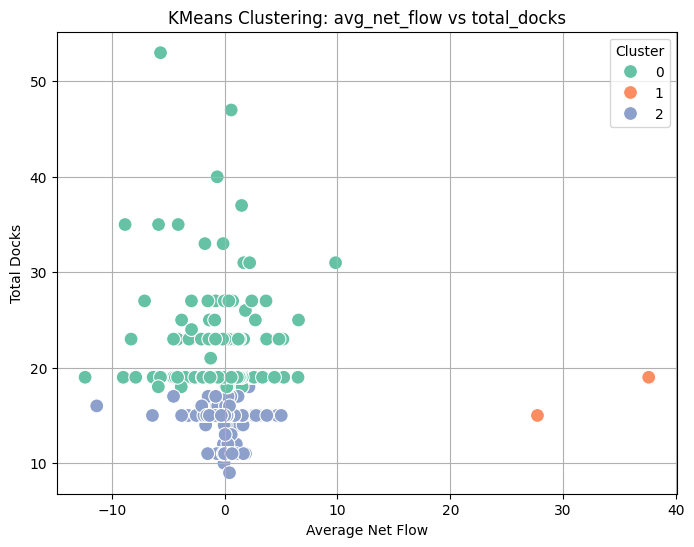

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=clusterdata,
    x="avg_net_flow",
    y="total_docks",
    hue="cluster_kmeans",
    palette="Set2",
    s=100
)
plt.title("KMeans Clustering: avg_net_flow vs total_docks")
plt.xlabel("Average Net Flow")
plt.ylabel("Total Docks")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()
